In [1]:
# CUDA関数、位相回復ホログラフィの実装

using CUDA
using CUDA.CUFFT

# 伝達関数のルートの中身。CUDA関数とわかるように Cu から始まる名前にしています。
function CuTransSqr!(Plane, datLen, wavLen, dx)
    x = (blockIdx().x-1)*blockDim().x + threadIdx().x
    y = (blockIdx().y-1)*blockDim().y + threadIdx().y
    if x <= datLen && y <= datLen
        Plane[y,x] = 1.0 - ((x-datLen/2)*wavLen/datLen/dx)^2 - ((y-datLen/2)*wavLen/datLen/dx)^2
    end
    return nothing # CUDA 関数は return してはいけません。Plane を変更する関数です。関数名の ! は引数の配列を変更する破壊的関数であることを示しています。
end

# 伝達関数
function CuTransFunc!(Plane, d_sqrPart, z0, wavLen, datLen,dx)
    x = (blockIdx().x-1)*blockDim().x + threadIdx().x
    y = (blockIdx().y-1)*blockDim().y + threadIdx().y
    uband = 1.0/wavLen/sqrt(2.0*z0/datLen/dx + 1.0)
    tmpx = abs((x-datLen/2.0)*wavLen/datLen/dx)
    tmpy = abs((y-datLen/2.0)*wavLen/datLen/dx)
    if x <= datLen && y <= datLen
        if tmpx > uband || tmpy > uband
            Plane[y,x] = 0.0
        else
            Plane[y,x] = exp(2im*pi*(z0)/wavLen*sqrt(d_sqrPart[y,x]))
        end
        # Plane[y,x] = exp(2im*pi*(z0)/wavLen*sqrt(d_sqrPart[y,x]))
    end
    return nothing
end

# 位相回復。ボールレンズでは　iterations = 10、 ハーフボールレンズでは 11。(松村さん論文より)
function CuPhaseRetrieval!(Plane, img1, img2, trans, transInv, iterations, datLen)
    compAmp1 = CuArray{ComplexF32}(undef,(datLen,datLen))
    compAmp2 = CuArray{ComplexF32}(undef,(datLen,datLen))
    phi1 = CUDA.ones(datLen,datLen)
    phi2 = CuArray{Float32}(undef,(datLen,datLen))

    sqrtImg1 = sqrt.(img1)
    sqrtImg2 = sqrt.(img2)

    compAmp1 = sqrtImg1.*1.0

    for itr in 1:iterations
        # STEP 1
        compAmp2 = CUFFT.ifft(CUFFT.fftshift(CUFFT.fftshift(CUFFT.fft(compAmp1)).*trans))
        phi2 = angle.(compAmp2) # angle() は複素数の偏角を返す関数。ドットをつけて angle.() で Element-wise な演算をします。
        # STEP 2
        compAmp2 = sqrtImg2.*exp.(1.0im.*phi2)
        # STEP 3
        compAmp1 = CUFFT.ifft(CUFFT.fftshift(CUFFT.fftshift(CUFFT.fft(compAmp2)).*transInv))
        phi1 = angle.(compAmp1)
        # STEP 4
        compAmp1 = sqrtImg1.*exp.(1.0im.*phi1)
    end

    Plane .= compAmp1
    return nothing # CUDA 関数は return してはいけません。
end

# function CuBallLensField!(Plane, diam, noil, nlens, wavLen, datLen,dx)
#     x = (blockIdx().x-1)*blockDim().x + threadIdx().x
#     y = (blockIdx().y-1)*blockDim().y + threadIdx().y

#     if x <= datLen && y <= datLen
#         if (x-datLen/2.0)^2+(y-datLen/2.0)^2 <= diam^2/4/dx/dx
#             Plane[y,x] = exp(1.0im*(2.0*CUDA.pi/wavLen*noil*diam + 4.0*CUDA.pi/wavLen*(nlens-noil)*sqrt( (diam/2)^2 - ((dx*(x-datLen/2.0))^2+(dx*(y-datLen/2.0))^2) )))
#         else
#             Plane[y,x] = exp(1.0im*2.0*CUDA.pi/wavLen*noil*diam)
#         end
#     end

#     return nothing
# end

function CuValidObj!(Plane,diam,datLen,dx)
    x = (blockIdx().x-1)*blockDim().x + threadIdx().x
    y = (blockIdx().y-1)*blockDim().y + threadIdx().y

    if x <= datLen && y <= datLen
        if abs(y-datLen/2)*dx*2 > diam # um
            Plane[y,x] = 0.0
        elseif (x-datLen/2.0)^2+(y-datLen/2.0)^2 <= diam^2/4/dx/dx
                Plane[y,x] = 1.0
        else
                Plane[y,x] = 0.5
        end
    end

    return nothing
end

function CuValidPhase!(Plane,diam,noil,nvinyl,nd,wavLen,datLen,dx)
    x = (blockIdx().x-1)*blockDim().x + threadIdx().x
    y = (blockIdx().y-1)*blockDim().y + threadIdx().y

    if x <= datLen && y <= datLen
        if abs(y-datLen/2)*dx*2 > diam # um
            # Plane[y,x] = 2.0*CUDA.pi/wavLen*nvinyl*diam
            Plane[y,x] = 0.0
        elseif (x-datLen/2.0)^2+(y-datLen/2.0)^2 <= diam^2/4/dx/dx
                # Plane[y,x] = 2.0*CUDA.pi/wavLen*noil*diam + 4.0*CUDA.pi/wavLen*(nd-noil)*sqrt( (diam/2)^2 - ((dx*(x-datLen/2.0))^2+(dx*(y-datLen/2.0))^2) )
                Plane[y,x] = 4.0*CUDA.pi/wavLen*(nd-noil)*sqrt( (diam/2)^2 - ((dx*(x-datLen/2.0))^2+(dx*(y-datLen/2.0))^2) )
        else
                # Plane[y,x] = 2.0*CUDA.pi/wavLen*noil*diam
                Plane[y,x] = 0.0
        end
    end

    return nothing
end

function CuTubeField!(Plane, diam, noil, nvinyl, wavLen, datLen,dx)
    x = (blockIdx().x-1)*blockDim().x + threadIdx().x
    y = (blockIdx().y-1)*blockDim().y + threadIdx().y

    if x <= datLen && y <= datLen
        if abs(y-datLen/2)*dx*2 > diam # um
            Plane[y,x] = exp(1.0im*2.0*CUDA.pi/wavLen*nvinyl*diam)
        else
                Plane[y,x] = exp(1.0im*2.0*CUDA.pi/wavLen*noil*diam)
        end
    end

    return nothing
end

function CuPhaseField!(Plane, diam, noil, nvinyl, nd, wavLen, datLen,dx)
    x = (blockIdx().x-1)*blockDim().x + threadIdx().x
    y = (blockIdx().y-1)*blockDim().y + threadIdx().y

    if x <= datLen && y <= datLen
        if abs(y-datLen/2)*dx*2 > diam # um
            Plane[y,x] = exp(1.0im*2.0*CUDA.pi/wavLen*nvinyl*diam)
        elseif (x-datLen/2.0)^2+(y-datLen/2.0)^2 <= diam^2/4/dx/dx
                Plane[y,x] = exp(1.0im*(2.0*CUDA.pi/wavLen*noil*diam + 4.0*CUDA.pi/wavLen*(nd-noil)*sqrt( (diam/2)^2 - ((dx*(x-datLen/2.0))^2+(dx*(y-datLen/2.0))^2) )))
        else
                Plane[y,x] = exp(1.0im*2.0*CUDA.pi/wavLen*noil*diam)
        end
    end

    return nothing
end

CuPhaseField! (generic function with 1 method)

In [267]:
# Making Holos
using Images
using Plots

wavLen = 0.6328 # um
imgLen = 1024 # pixels
datLen = imgLen*2 # pixels
dx = 3.45 # um
# dx = 10.0 # um
# z1 = 180000.0 # um
z1 = 50000.0 # um
# z2 = 240000.0 # um
z2 = 100000.0 # um
dz = z2 - z1 # um
# diam = 150.0 # um
diam = 100.0 # um
# noil = 1.51253
noil = 1.51253
nvinyl = 1.51509
# nvinyl = 1.51253 # 流路はガラス製？
# nd = 1.51509
nd = 1.52
# nd = 1.51509

threads = (32,32)
blocks = (cld(datLen,32),cld(datLen,32))

sqr = CuArray{Float32}(undef,(datLen,datLen))
transz1 = CuArray{ComplexF32}(undef,(datLen,datLen))
transz2 = CuArray{ComplexF32}(undef,(datLen,datLen))
transdz = CuArray{ComplexF32}(undef,(datLen,datLen))
transInvdz = CuArray{ComplexF32}(undef,(datLen,datLen))
transPR = CuArray{ComplexF32}(undef,(datLen,datLen))
transInvPR = CuArray{ComplexF32}(undef,(datLen,datLen))
phaseField = CuArray{ComplexF32}(undef,(datLen,datLen))
prField = CuArray{ComplexF32}(undef,(datLen,datLen))
d_obj = CuArray{Float32}(undef,(datLen,datLen))
d_theory = CuArray{Float32}(undef,(datLen,datLen))
d_tube = CuArray{ComplexF32}(undef,(datLen,datLen))
@cuda threads = threads blocks = blocks CuTubeField!(d_tube,diam,noil,nvinyl,wavLen,datLen,dx)
d_tube .= d_tube .* 0.5
@cuda threads = threads blocks = blocks CuValidPhase!(d_theory,diam,noil,nvinyl,nd,wavLen,datLen,dx)
@cuda threads = threads blocks = blocks CuValidObj!(d_obj,diam,datLen,dx)
@cuda threads = threads blocks = blocks CuPhaseField!(phaseField, diam,noil,nvinyl,nd,wavLen,datLen,dx)
phaseField .= phaseField .* 0.5
# tmp = CUFFT.ifft(CUFFT.fftshift(CUFFT.fftshift(CUFFT.fft(phaseField))))
# save("objraw.png",Array(Float32.(abs.(tmp.*conj.(tmp)))))
# save("objraw.png",Array(Float32.(abs.(phaseField.*conj.(phaseField)))))
@cuda threads = threads blocks = blocks CuTransSqr!(sqr,datLen,wavLen,dx)
@cuda threads = threads blocks = blocks CuTransFunc!(transz1,sqr,z1-diam,wavLen,datLen,dx)
@cuda threads = threads blocks = blocks CuTransFunc!(transz2,sqr,z2-diam,wavLen,datLen,dx)
# @cuda threads = threads blocks = blocks CuTransFunc!(transdz,sqr,dz,wavLen,datLen,dx)
# @cuda threads = threads blocks = blocks CuTransFunc!(transInvdz,sqr,-dz,wavLen,datLen,dx)
@cuda threads = threads blocks = blocks CuTransFunc!(transPR,sqr,z2-z1,wavLen,datLen,dx)
@cuda threads = threads blocks = blocks CuTransFunc!(transInvPR,sqr,z1-z2,wavLen,datLen,dx)


d_holo1 = CUFFT.ifft(CUFFT.fftshift(CUFFT.fftshift(CUFFT.fft(phaseField)).*transz1)) # ドットをつけて .* で　Element-wise な演算
d_holo2 = CUFFT.ifft(CUFFT.fftshift(CUFFT.fftshift(CUFFT.fft(phaseField)).*transz2))
d_img1 = abs.(d_holo1.*conj(d_holo1))
d_img2 = abs.(d_holo2.*conj(d_holo2))

img1 = Array(Float32.(d_img1))
img2 = Array(Float32.(d_img2))

d_tubeimg1 = CUFFT.ifft(CUFFT.fftshift(CUFFT.fftshift(CUFFT.fft(d_tube)).*transz1))
d_tubeimg2 = CUFFT.ifft(CUFFT.fftshift(CUFFT.fftshift(CUFFT.fft(d_tube)).*transz2))

d_tubeimg1 = abs.(d_tubeimg1.*conj(d_tubeimg1))
d_tubeimg2 = abs.(d_tubeimg2.*conj(d_tubeimg2))
tubeimg1 = Array(Float32.(d_tubeimg1))
tubeimg2 = Array(Float32.(d_tubeimg2))


function boundcheck(Plane,datLen)
    for y in 1:datLen
        for x in 1:datLen
            if Plane[y,x] > 1.0
                Plane[y,x] = 1.0
            end
        end
    end
end

boundcheck(img1,datLen)
boundcheck(img2,datLen)
boundcheck(tubeimg1,datLen)
boundcheck(tubeimg2,datLen)


save("img1.png",img1[Int(imgLen/2)+1:Int(imgLen/2)+imgLen,Int(imgLen/2)+1:Int(imgLen/2)+imgLen])
save("img2.png",img2[Int(imgLen/2)+1:Int(imgLen/2)+imgLen,Int(imgLen/2)+1:Int(imgLen/2)+imgLen])
save("tube1.png",tubeimg1[Int(imgLen/2)+1:Int(imgLen/2)+imgLen,Int(imgLen/2)+1:Int(imgLen/2)+imgLen])
save("tube2.png",tubeimg2[Int(imgLen/2)+1:Int(imgLen/2)+imgLen,Int(imgLen/2)+1:Int(imgLen/2)+imgLen])
save("obj.png",Array(d_obj)[Int(imgLen/2)+1:Int(imgLen/2)+imgLen,Int(imgLen/2)+1:Int(imgLen/2)+imgLen])
# save("img1.png",img1)
# save("img2.png",img2)
# save("tube1.png",tubeimg1)
# save("tube2.png",tubeimg2)
# save("obj.png",Array(d_obj))



In [273]:
# Inputting Images, Comparison
using Images
using StatsBase
using CUDA
using Plots
using ImageView

function loadholo(path::String)
    out = Float32.(channelview(Gray.(load(path))))
end

function makeholo(holo,img,bkg,setvalue,datLen)
    imgLen = Int(datLen/2)
    tmpLen = Int(imgLen/2)
    holo[tmpLen+1:tmpLen+imgLen,tmpLen+1:tmpLen+imgLen] .= sqrt.(img) .- sqrt.(bkg) .+ setvalue .+ 0im
end 

function makeimg(img,bkg,setvalue,diffvalue,datLen)
    out = fill(setvalue,(datLen,datLen))
    out[Int(datLen/4)+1:Int(datLen/4)+Int(datLen/2),Int(datLen/4)+1:Int(datLen/4)+Int(datLen/2)] .= img .- bkg .+ diffvalue
    # out .= img .- bkg .+ diffvalue
    return out
end 

function errorRetouch(pr,theory,datLen,diam,dx)
    # for idx in 1:datLen*datLen
    #     if pr[idx] < theory[idx]
    #         while (pr[idx]+2pi-theory[idx])^2 < (pr[idx]-theory[idx])^2
    #             pr[idx] += 2pi
    #         end
    #     # else
    #     #     while (pr[idx]-2pi-theory[idx])^2 < (pr[idx]-theory[idx])^2
    #     #         pr[idx] -= 2pi
    #     #     end
    #     end
    # end

    for y in 1:datLen
        for x in 1:datLen
            if (x-datLen/2)^2+(y-datLen/2)^2 <= (diam/dx/2)^2 + 1
                while (pr[y,x]+2pi-theory[y,x])^2 < (pr[y,x]-theory[y,x])^2
                    pr[y,x] += 2pi
                end
            end
        end
    end
    return nothing
end

img1 = loadholo("./img1.png")
img2 = loadholo("./img2.png")
tube1 = loadholo("./tube1.png")
tube2 = loadholo("./tube2.png")

# inholo1 = Array{ComplexF32}(undef,(datLen,datLen))
# fill!(inholo1,0.5+0im)
# inholo2 = Array{ComplexF32}(undef,(datLen,datLen))
# fill!(inholo2,0.5+0im)

# makeholo(inholo1,img1,tube1,0.5,datLen)
# makeholo(inholo2,img2,tube2,0.5,datLen)

prIter = 30

# display(img1)
# imshow(Float32.(inholo2))
# imshow(img1.-tube1 .+ 0.5)
d_in1 = cu(makeimg(img1,0.0,0.5^2,0.0,datLen))
d_in1 = cu(makeimg(img1,tube1,0.5^2,0.5^2,datLen))
save("d_in1.png",Array(d_in1))
# save("d_in1_.png",Array(d_in1_))
# display(d_in1)
d_in2 = cu(makeimg(img2,0.0,0.5^2,0.0,datLen))
d_in2 = cu(makeimg(img2,tube2,0.5^2,0.5^2,datLen))
save("d_in2.png",Array(d_in2))
# save("d_in2_.png",Array(d_in2_))


CuPhaseRetrieval!(prField, d_in1, d_in2, transPR, transInvPR, prIter, datLen)
# prField
# d_in1
transInvZ = CuArray{ComplexF32}(undef,(datLen,datLen))
@cuda threads = threads blocks = blocks CuTransFunc!(transInvZ,sqr,-z1+diam,wavLen,datLen,dx)
prRec = CUFFT.ifft(CUFFT.fftshift(CUFFT.fftshift(CUFFT.fft(prField)).*transInvZ)) .* exp(-2.0im*pi/wavLen*noil*diam)
prRecPhase = Array(angle.(prRec)) #.- 2.0pi/wavLen*noil*diam 
# coef = cld(-minimum(prRecPhase),2pi)-1
# prRecPhase .+= coef*2pi

halfvisrange = 50
prout = prRecPhase[Int(datLen/2)-halfvisrange+1:Int(datLen/2)+halfvisrange,Int(datLen/2)-halfvisrange+1:Int(datLen/2)+halfvisrange]
theoryout = Array(d_theory)[Int(datLen/2)-halfvisrange+1:Int(datLen/2)+halfvisrange,Int(datLen/2)-halfvisrange+1:Int(datLen/2)+halfvisrange];
# errorRetouch(prout,theoryout,61)
# wireframe(prout)
# wireframe!(theoryout)
# xaxis = collect(Int(datLen/2)-halfvisrange+1:Int(datLen/2)+halfvisrange)
# errorRetouch(prout,theoryout,halfvisrange*2,diam,dx)
# plot(xaxis,theoryout[halfvisrange,:],label="theory", xlabel="x [pixels]", ylabel="Phase [rad]",title="Radius: 450μm")
# plot!(xaxis,prout[halfvisrange,:],label="PR")

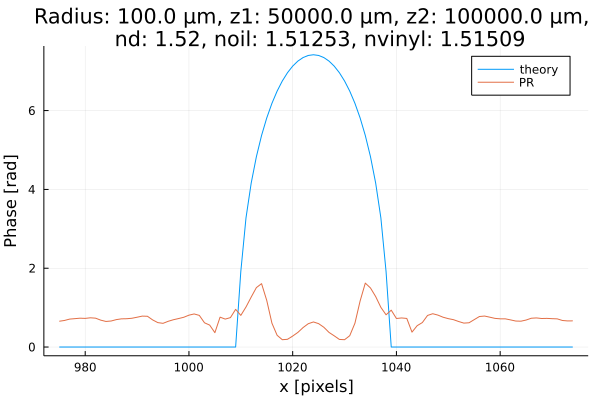

In [274]:
xaxis = collect(Int(datLen/2)-halfvisrange+1:Int(datLen/2)+halfvisrange)
plot(xaxis,theoryout[halfvisrange,:],label="theory", xlabel="x [pixels]", ylabel="Phase [rad]", title="Radius: $diam μm, z1: $z1 μm, z2: $z2 μm, \n nd: $nd, noil: $noil, nvinyl: $nvinyl")
plot!(xaxis,prout[halfvisrange,:],label="PR")

In [275]:
prout .= prout .- prout[halfvisrange,1].+theoryout[halfvisrange,1]
errorRetouch(prout,theoryout,halfvisrange*2,diam,dx)
# wireframe(prout)

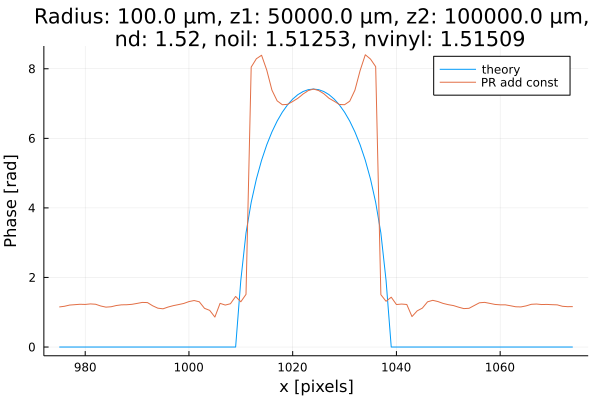

In [276]:
xaxis = collect(Int(datLen/2)-halfvisrange+1:Int(datLen/2)+halfvisrange)
plot(xaxis,theoryout[halfvisrange,:],label="theory", xlabel="x [pixels]", ylabel="Phase [rad]",title="Radius: $diam μm, z1: $z1 μm, z2: $z2 μm, \n nd: $nd, noil: $noil, nvinyl: $nvinyl")
# plot!(xaxis,prout[halfvisrange,:].-0.7,label="PR raw")
plot!(xaxis,prout[halfvisrange,:].-(prout[halfvisrange,halfvisrange] - theoryout[halfvisrange,halfvisrange]),label="PR add const")
# addconst = rmsd(theoryout[halfvisrange,halfvisrange-Int(floor(diam/2/dx))+1:halfvisrange+Int(floor(diam/2/dx))],theoryout[halfvisrange,halfvisrange-Int(floor(diam/2/dx))+1:halfvisrange+Int(floor(diam/2/dx))])
# if prout[halfvisrange,halfvisrange] > theoryout[halfvisrange,halfvisrange]
#     plot!(xaxis,prout[halfvisrange,:].-addconst,label="PR add const")
# else
#     plot!(xaxis,prout[halfvisrange,:].+addconst,label="PR add const")
# end

In [172]:
# wireframe(prout)
# wireframe(theoryout)